In [4]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [5]:
mobile_net = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=(224, 224, 3))
])

In [6]:
import requests
target_url = "https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt"
response = requests.get(target_url)
labels = response.text.split("\n")

In [7]:
img = Image.open("potpie.jpg")

In [8]:
potpie = img.resize((224, 224))
potpie = np.array(potpie)/255.0
potpie = potpie[np.newaxis, ...]

In [9]:
pred = mobile_net.predict(potpie)
pred

1/1 [==============================] - 79s 79s/step


array([[ 0.37158248,  1.0987326 , -0.62154   , ...,  1.9407569 ,
         0.13099512,  1.1240891 ]], dtype=float32)

In [10]:
labels[np.argmax(pred)]

'potpie'

In [11]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)

228813984/228813984 [==============================] - 77s 0us/step


In [12]:
data_dir

'C:\\Users\\Shashank\\.keras\\datasets\\flower_photos'

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/Shashank/.keras/datasets/flower_photos')

In [14]:
img_count = len(list(data_dir.glob("*/*.jpg")))
img_count

3670

In [15]:
flower_img_dict = {}
flower_labels = {}
b=0
for flower in os.listdir(data_dir):
    if flower=="LICENSE.txt": continue
    flower_img_dict[flower] = list(data_dir.glob(flower+"/*.jpg"))
    flower_labels[flower] = b
    b+=1

In [16]:
img = cv2.imread(str(flower_img_dict["roses"][54]))
img.shape

(333, 500, 3)

In [17]:
X, y = [], []
import tqdm.notebook as nb
pb = nb.tqdm(total = img_count)
for flower, images in flower_img_dict.items():
    for image in images:
        pb.update(n=1)
        img = cv2.imread(str(image))
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(flower_labels[flower])

  0%|          | 0/3670 [00:00<?, ?it/s]

In [18]:
predicted = mobile_net.predict(np.array([X[0], X[1], X[2]]))
predicted = [np.argmax(i) for i in predicted]
predicted

1/1 [==============================] - 7s 7s/step


[795, 795, 795]

(<matplotlib.image.AxesImage at 0x2147932e770>, 'pillow')

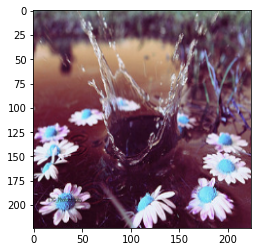

In [19]:
plt.imshow(X[2]), labels[722]

In [20]:
from sklearn.model_selection import train_test_split as tts
X = np.array(X)/255.0
y = np.array(y)

x_train, x_test, y_train, y_test = tts(X, y, random_state=42)

MemoryError: Unable to allocate 4.12 GiB for an array with shape (3670, 224, 224, 3) and data type float64

In [ ]:
feature_ext = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

features = hub.KerasLayer(feature_ext, input_shape=(224, 224, 3), trainable=False)

In [ ]:
model = keras.Sequential([
                          features,
                          tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=["acc"])
model.fit(x_train, y_train, epochs=5)